In [1]:
import os
import cv2
import torch
import random
import numpy as np
from PIL import Image
from torch import optim
from collections import deque
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import Conv_Att_MCI_Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from models import BaseModel, VGG16GradCAM, ConvAttnModel

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Dataset
img_type = ['clock'] #all, clock, copy, trail
is_soft_label = False

# Model
model_type = 'conv_att' # base, vgg16_grad_cam, conv_att
backbone_freezing = False
## Conv-Att
h_dim_attn = 128
n_heads = 1
h_dim_fc = 512
n_layers = 1

# training
batch_size = 32#64
n_epochs = 100
best_loss = np.inf
best_epoch = 0
best_flag = False

# optimizer
lr = 1e-5
beta_1 = 0.9
beta_2 = 0.99
eps = 1e-7
backbone_lr = 1e-6

## Early stopping
es_size = 4

# Save directory
savedir = './checkpoint/img_%s/model_%s/freeze_%s'%('_'.join(img_type), model_type, '%s'%backbone_freezing+'_lr_%s'%backbone_lr if not backbone_freezing else backbone_freezing)
if model_type == 'conv_att':
    savedir = os.path.join(savedir, 'h_dim_attn_%d_n_heads_%d_h_dim_fc_%d_n_layers_%d'%(h_dim_attn, n_heads, h_dim_fc, n_layers))
savedir = os.path.join(savedir, 'soft_label_%s'%is_soft_label)
savedir = os.path.join(savedir, 'seed_%d'%SEED)
os.makedirs(savedir, exist_ok=True)

In [4]:
dataset = Conv_Att_MCI_Dataset(img_type, is_soft_label)
dataset_trn, dataset_val, dataset_test = dataset.split_trn_val_test()
dataloader_trn = DataLoader(dataset_trn, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [5]:
if model_type == 'base':
    model = BaseModel(img_type, backbone_freezing).to(device)
elif model_type == 'vgg16_grad_cam':
    model = VGG16GradCAM(img_type, backbone_freezing).to(device)
elif model_type == 'conv_att':
    model = ConvAttnModel(img_type, h_dim_attn, n_heads, h_dim_fc, n_layers, backbone_freezing).to(device)
else:
    raise ValueError("%s is invalid type"%model_type)

/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
n_tot, n_params_trn, n_params_frozen = 0,0,0
for n,p in model.named_parameters():
    n_tot += p.numel()
    if p.requires_grad:
        n_params_trn += p.numel()
    else:
        n_params_frozen += p.numel()
print("| Total # parameters %d | Trainable %d | Frozen %d |"%(n_tot, n_params_trn, n_params_frozen))

| Total # parameters 14978882 | Trainable 14978882 | Frozen 0 |


In [7]:
common_settings = {'betas':[beta_1, beta_2], 'eps':eps}

backbone_params, others_params = {'names':[], 'params':[]},{'names':[], 'params':[]}
for n,p in model.named_parameters():
    if 'vgg16' in n:
        backbone_params['names'].append(n)
        backbone_params['params'].append(p)
    else:
        others_params['names'].append(n)
        others_params['params'].append(p)

optimizer = optim.Adam([
    {'params':backbone_params['params'], 'lr':backbone_lr, **common_settings},
    {'params':others_params['params'], 'lr':lr, **common_settings},
])

In [8]:
def save_ckpt(epoch, model, optimizer, results, savepath):
    ckpt = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': results['losses']['val'][-1],
        'acc': results['accs']['val'][-1],
        'results': results
    }
    torch.save(ckpt, savepath)
    return ckpt

In [9]:
results = {
    'losses':{'trn':[], 'val':[], 'test':[]},
    'corrects':{'trn':[], 'val':[], 'test':[]},
    'accs':{'trn':[], 'val':[], 'test':[]},
}
es_queue, es_flag = deque(maxlen=es_size), False
for epoch in range(n_epochs):
    _losses, _corrects, n_tot = [],[],0
    model.train()
    for x, y, info in dataloader_trn:
        for i in range(len(x)):
            x[i] = x[i].to(device)
        y = y.to(device)

        y_pred = model(x)
        y_prob = y_pred.softmax(-1)[:,1]
        loss = F.binary_cross_entropy(y_prob, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _correct = ((y_prob.cpu() >= 0.5) == info['labels']).sum()

        _losses.append(loss.item())
        _corrects.append(_correct)
        n_tot += len(x[-1])
    
    accs = sum(_corrects) / n_tot *100
    results['losses']['trn'].append(np.mean(_losses))
    results['corrects']['trn'].append(sum(_corrects))
    results['accs']['trn'].append(accs)

    _losses, _corrects, n_tot = [],[],0
    model.eval()
    for x, y, info in dataloader_val:
        for i in range(len(x)):
            x[i] = x[i].to(device)
        y = y.to(device)

        y_pred = model(x)
        y_prob = y_pred.softmax(-1)[:,1]
        loss = F.binary_cross_entropy(y_prob, y)

        _correct = ((y_prob.cpu() >= 0.5) == info['labels']).sum()

        _losses.append(loss.item())
        _corrects.append(_correct)
        n_tot += len(x[-1])
    
    accs = sum(_corrects) / n_tot *100
    results['losses']['val'].append(np.mean(_losses))
    results['corrects']['val'].append(sum(_corrects))
    results['accs']['val'].append(accs)

    _losses, _corrects, n_tot = [],[],0
    model.eval()
    for x, y, info in dataloader_test:
        for i in range(len(x)):
            x[i] = x[i].to(device)
        y = y.to(device)

        y_pred = model(x)
        y_prob = y_pred.softmax(-1)[:,1]
        loss = F.binary_cross_entropy(y_prob, y)

        _correct = ((y_prob.cpu() >= 0.5) == info['labels']).sum()

        _losses.append(loss.item())
        _corrects.append(_correct)
        n_tot += len(x[-1])
    
    accs = sum(_corrects) / n_tot *100
    results['losses']['test'].append(np.mean(_losses))
    results['corrects']['test'].append(sum(_corrects))
    results['accs']['test'].append(accs)  

    es_queue.append(results['losses']['val'][-1])
    if len(es_queue) >= es_size:
        if (np.diff(es_queue) >= 0).all() and (np.diff(results['losses']['trn'][-es_size:]) < 0).all():
            es_flag = True

    if best_loss >= results['losses']['val'][-1]:
        best_loss = results['losses']['val'][-1]
        best_epoch = epoch
        best_flag = True
        savepath = os.path.join(savedir, 'model_best.ckpt')
        best_ckpt = save_ckpt(epoch, model, optimizer, results, savepath)
        
    print("| Epoch %d/%d |"%(epoch+1, n_epochs), end=' Early stopping!\n' if es_flag else '\n')
    print("| Train      | Loss %6.2f | Acc. %6.2f |"%(results['losses']['trn'][-1], results['accs']['trn'][-1]))
    print("| Validation | Loss %6.2f | Acc. %6.2f |"%(results['losses']['val'][-1], results['accs']['val'][-1]), end=' Best\n' if best_flag else '\n')
    print("| Test       | Loss %6.2f | Acc. %6.2f |"%(results['losses']['test'][-1], results['accs']['test'][-1]))
    best_flag = False
    savepath = os.path.join(savedir, 'model.ckpt')
    epoch_ckpt = save_ckpt(epoch, model, optimizer, results, savepath)
    
    if es_flag:
        break

open(os.path.join(savedir, 'Best_epoch_%d_loss_%6.2f_acc_%6.2f'%(best_ckpt['epoch'], best_ckpt['loss'], best_ckpt['acc'])), 'w')
open(os.path.join(savedir, 'Final_%d_loss_%6.2f_acc_%6.2f'%(epoch_ckpt['epoch'], epoch_ckpt['loss'], epoch_ckpt['acc'])), 'w')

print('Best_epoch_%d_loss_%6.2f_acc_%6.2f'%(best_ckpt['epoch'], best_ckpt['loss'], best_ckpt['acc']))
print('Final_%d_loss_%6.2f_acc_%6.2f'%(epoch_ckpt['epoch'], epoch_ckpt['loss'], epoch_ckpt['acc']))

| Epoch 1/100 |
| Train      | Loss   0.70 | Acc.  58.86 |
| Validation | Loss   0.64 | Acc.  64.23 | Best
| Test       | Loss   0.68 | Acc.  60.87 |
| Epoch 2/100 |
| Train      | Loss   0.67 | Acc.  63.37 |
| Validation | Loss   0.67 | Acc.  63.50 |
| Test       | Loss   0.69 | Acc.  64.49 |
| Epoch 3/100 |
| Train      | Loss   0.65 | Acc.  67.34 |
| Validation | Loss   0.64 | Acc.  67.52 | Best
| Test       | Loss   0.65 | Acc.  70.65 |
| Epoch 4/100 |
| Train      | Loss   0.63 | Acc.  68.74 |
| Validation | Loss   0.65 | Acc.  69.71 |
| Test       | Loss   0.68 | Acc.  68.48 |
| Epoch 5/100 |
| Train      | Loss   0.65 | Acc.  68.51 |
| Validation | Loss   0.61 | Acc.  70.07 | Best
| Test       | Loss   0.66 | Acc.  72.10 |
| Epoch 6/100 |
| Train      | Loss   0.62 | Acc.  70.30 |
| Validation | Loss   0.65 | Acc.  68.61 |
| Test       | Loss   0.64 | Acc.  70.65 |
| Epoch 7/100 |
| Train      | Loss   0.62 | Acc.  69.60 |
| Validation | Loss   0.67 | Acc.  68.25 |
| Test       

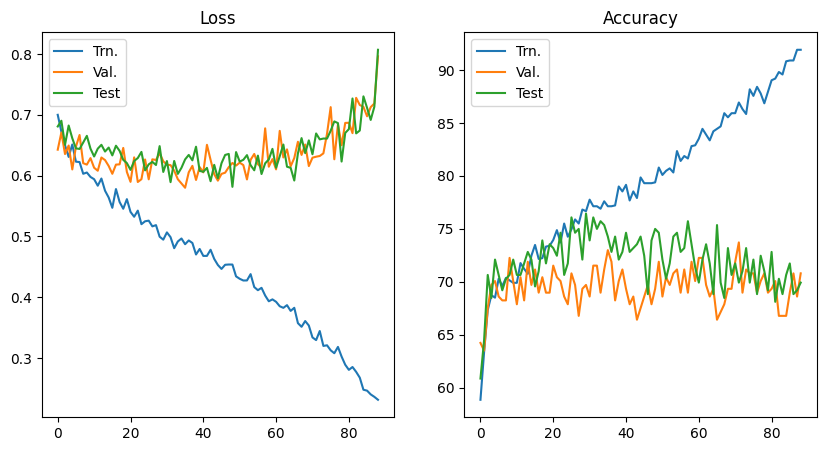

In [10]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(1,2,1)
ax.plot(results['losses']['trn'], label='Trn.')
ax.plot(results['losses']['val'], label='Val.')
ax.plot(results['losses']['test'], label='Test')
ax.vlines(best_ckpt['epoch'], *ax.axis()[2:], colors='red', linestyles='dashed', linewidth=0.3)
ax.legend()
ax.set_title('Loss')

ax = fig.add_subplot(1,2,2)
ax.plot(results['accs']['trn'], label='Trn.')
ax.plot(results['accs']['val'], label='Val.')
ax.plot(results['accs']['test'], label='Test')
ax.vlines(best_ckpt['epoch'], *ax.axis()[2:], colors='red', linestyles='dashed', linewidth=0.3)
ax.legend()
ax.set_title('Accuracy')

savepath_lc = os.path.join(savedir, 'learning_curve.png')
plt.savefig(savepath_lc)

# Test model

## Release GPU memory

In [11]:
del model, x, y
torch.cuda.empty_cache()

In [12]:
if model_type == 'base':
    model = BaseModel(img_type, backbone_freezing).to(device)
elif model_type == 'vgg16_grad_cam':
    model = VGG16GradCAM(img_type, backbone_freezing).to(device)
elif model_type == 'conv_att':
    model = ConvAttnModel(img_type, h_dim_attn, n_heads, h_dim_fc, n_layers, backbone_freezing).to(device)
else:
    raise ValueError("%s is invalid type"%model_type)

In [13]:
loadpath = os.path.join(savedir, 'model_best.ckpt')
ckpt = torch.load(loadpath)

model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [43]:
best_ckpt

{'epoch': 35,
 'model_state_dict': OrderedDict([('vgg16_models.0.0.weight',
               tensor([[[[-5.5337e-01,  1.4296e-01,  5.2907e-01],
                         [-5.8289e-01,  3.5673e-01,  7.6574e-01],
                         [-6.9005e-01, -4.7881e-02,  4.8415e-01]],
               
                        [[ 1.7584e-01,  1.0117e-02, -8.1306e-02],
                         [ 4.4328e-02, -7.0146e-02, -2.6028e-01],
                         [ 1.3257e-01, -1.7265e-01, -1.3220e-01]],
               
                        [[ 3.1338e-01, -1.6566e-01, -4.2742e-01],
                         [ 4.7543e-01, -8.2501e-02, -4.8693e-01],
                         [ 6.3220e-01,  1.9445e-02, -2.7747e-01]]],
               
               
                       [[[ 2.3262e-01,  1.2678e-01,  1.8622e-01],
                         [-4.2792e-01, -2.4333e-01,  2.4645e-01],
                         [-2.5049e-01,  1.4197e-01, -5.2911e-03]],
               
                        [[-1.4068e-01, -2.1891e

In [14]:
_losses, _corrects, n_tot = [],[],0
ys, y_preds = [],[]
model.eval()
for x, y, info in dataloader_test:
    for i in range(len(x)):
        x[i] = x[i].to(device)
    y = y.to(device)

    y_pred = model(x)
    y_prob = y_pred.softmax(-1)[:,1]
    loss = F.binary_cross_entropy(y_prob, y)

    _correct = ((y_prob.cpu() >= 0.5) == info['labels']).sum()

    _losses.append(loss.item())
    _corrects.append(_correct)
    n_tot += len(x[-1])

    y_preds.append(y_pred.detach().cpu())
    ys.append(info['labels'])

accs = sum(_corrects) / n_tot *100
open(os.path.join(savedir, 'Best_testset_loss_%6.2f_acc_%6.2f'%(np.mean(_losses), accs)), 'w')
print('Best_testset_loss_%6.4f_acc_%6.2f'%(np.mean(_losses), accs))

y_preds = torch.cat(y_preds)
ys = torch.cat(ys)

Best_testset_loss_0.7366_acc_ 69.57


In [15]:
if model_type == 'conv_att':
    def patch_attention(m):
        forward_orig = m.forward
    
        def wrap(*args, **kwargs):
            kwargs["need_weights"] = True
            kwargs["average_attn_weights"] = False
    
            return forward_orig(*args, **kwargs)
    
        m.forward = wrap
    attn_layers = []
    for i in range(len(dataset.img_type)):
        attn_layers.append(model.attns[i].layers[-1].self_attn)
        patch_attention(attn_layers[-1])
    
    vgg16_features, attn_inputs, attn_outputs = {_type:[] for _type in dataset.img_type}, {_type:[] for _type in dataset.img_type}, {_type:[] for _type in dataset.img_type}
    hooks = []
    for i, _type in enumerate(dataset.img_type):
      hooks.append(model.vgg16_models[i][-1].register_forward_hook(
          lambda self, input, output, _type=_type: vgg16_features[_type].append(output)
        ))
      hooks.append(attn_layers[i].register_forward_hook(
          lambda self, input, output, _type=_type: attn_inputs[_type].append(input[0])
        ))
      hooks.append(attn_layers[i].register_forward_hook(
          lambda self, input, output, _type=_type: attn_outputs[_type].append(output)
        ))

torch.Size([1, 3, 256, 256]) tensor([0.9890]) tensor([1.])


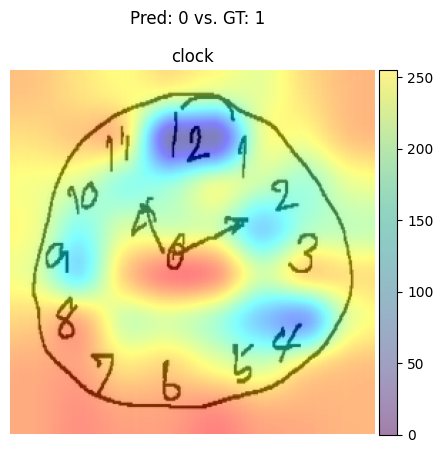

In [16]:
if model_type != 'base':
    idx = 130
    imgs = []
    for _type in dataset.img_type:
        imgs.append(dataset_test.dataset[_type][idx:idx+1].to(device))
    score = dataset_test.dataset['scores'][idx:idx+1]
    label = dataset_test.dataset['labels'][idx:idx+1]
    print(imgs[-1].shape, score, label)
    
    y_pred = model(imgs)
    if model_type == 'vgg16_grad_cam':
        # Grad-CAM
        class_idx = y_pred.argmax(-1).item()
        heatmaps = [heatmap.cpu() for heatmap in model.generate_cam(imgs, class_idx)]
    elif model_type == 'conv_att':
        # Self-attention
        for hook in hooks:
            hook.remove()
    
        heatmaps = []
        for _type in dataset.img_type:
            B,C,H,W = vgg16_features[_type][0].shape
        
            attn_weights = attn_outputs[_type][0][1]
            heatmap = attn_weights[:,0,0,1:].reshape(B,H,W).detach().cpu()
            heatmap = torch.clamp(heatmap, min=0)
            heatmap /= heatmap.max()
            heatmaps.append(heatmap)
    
    for i in range(len(heatmaps)):
        heatmaps[i] = np.uint8(255 * heatmaps[i])
        heatmaps[i] = np.uint8(Image.fromarray(heatmaps[i][0]).resize((imgs[-1].shape[2], imgs[-1].shape[3])))
        heatmaps[i] = cv2.applyColorMap(heatmaps[i], cv2.COLORMAP_JET)
    
    # alpha = 1.0
    # superimposed_img = heatmap * alpha #+ img[0].permute(1,2,0).detach().cpu().numpy()
    # superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    fig = plt.figure(figsize=(5*len(dataset.img_type), 5))
    fig.suptitle('Pred: %d vs. GT: %d'%(y_pred.argmax(-1).item(), label.item()))
    for i, _type in enumerate(dataset.img_type):
        ax = fig.add_subplot(1, len(dataset.img_type), i+1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
    
        im = ax.imshow(imgs[i][0].detach().cpu().permute(1,2,0))   
        ax.set_title(_type)
        im = ax.imshow(heatmaps[i], alpha=0.5)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax.axis('off')
    savepath_fig_res = os.path.join(savedir, 'results.png')
    plt.savefig(savepath_fig_res)